In [1]:
import pandas as pd
%matplotlib inline
news= pd.read_csv('./million-headlines/abcnews-date-text.csv',nrows=10000)

In [2]:
news.head(3)

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit


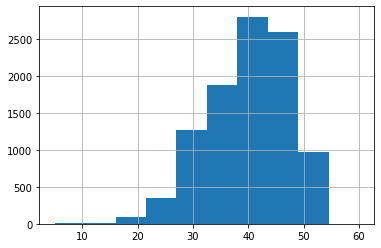

In [3]:
news['headline_text'].str.len().hist()

### average words in each sentence

In [4]:
def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist()

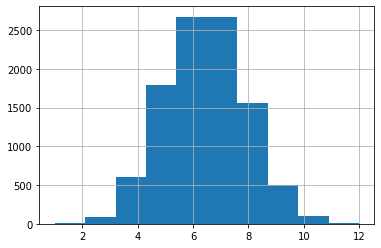

In [5]:
plot_word_number_histogram(news['headline_text'])

### average word length

In [6]:

import numpy as np

def plot_word_length_histogram(text):
    text.str.split().\
        apply(lambda x : [len(i) for i in x]). \
        map(lambda x: np.mean(x)).\
        hist()

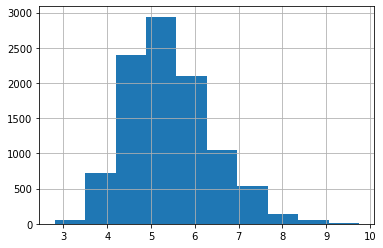

In [7]:
plot_word_length_histogram(news['headline_text'])

### stop words

In [11]:
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

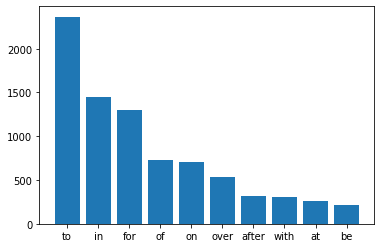

In [12]:
plot_top_stopwords_barchart(news['headline_text'])

In [13]:

import seaborn as sns
from nltk.corpus import stopwords
from collections import  Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)

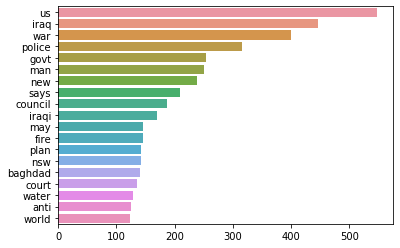

In [14]:
plot_top_non_stopwords_barchart(news['headline_text'])

#### top n grams

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter

def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)



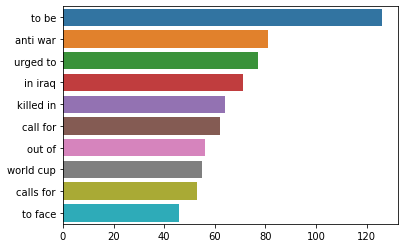

In [16]:
plot_top_ngrams_barchart(news['headline_text'],2)

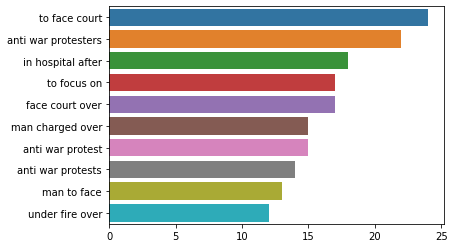

In [17]:
plot_top_ngrams_barchart(news['headline_text'],3)

### Topic Modeling Exploration

In [21]:
import nltk
from nltk.corpus import stopwords
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim


def get_lda_objects(text):
    nltk.download('stopwords')
    nltk.download('wordnet')
    stop=set(stopwords.words('english'))

    
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis

In [22]:
lda_model, bow_corpus, dic = get_lda_objects(news['headline_text'])


[nltk_data] Downloading package stopwords to /home/nikhil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nikhil/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [23]:
lda_model.show_topics()

[(0,
  '0.013*"war" + 0.013*"iraq" + 0.012*"man" + 0.007*"crash" + 0.007*"sars" + 0.007*"protest" + 0.006*"support" + 0.005*"killed" + 0.005*"car" + 0.005*"soldier"'),
 (1,
  '0.014*"baghdad" + 0.009*"death" + 0.007*"world" + 0.007*"iraqi" + 0.006*"cup" + 0.006*"report" + 0.005*"saddam" + 0.005*"force" + 0.005*"man" + 0.005*"police"'),
 (2,
  '0.021*"iraq" + 0.014*"war" + 0.009*"police" + 0.008*"govt" + 0.007*"say" + 0.006*"plan" + 0.005*"may" + 0.005*"claim" + 0.005*"win" + 0.005*"back"'),
 (3,
  '0.010*"new" + 0.006*"govt" + 0.006*"plan" + 0.005*"police" + 0.005*"council" + 0.005*"call" + 0.005*"boost" + 0.004*"water" + 0.004*"win" + 0.004*"troop"')]

In [24]:
plot_lda_vis(lda_model, bow_corpus, dic)

/home/nikhil/.local/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.049984  0.104227       1        1  27.656565
2     -0.130611  0.008050       2        1  25.080988
0      0.020412 -0.173468       3        1  23.749886
1      0.160183  0.061191       4        1  23.512562, topic_info=     Category        Freq     Term       Total  loglift  logprob
43    Default  429.000000     iraq  429.000000  30.0000  30.0000
3495  Default  194.000000  baghdad  194.000000  29.0000  29.0000
317   Default  203.000000      man  203.000000  28.0000  28.0000
163   Default  112.000000    death  112.000000  27.0000  27.0000
49    Default  389.000000      war  389.000000  26.0000  26.0000
...       ...         ...      ...         ...      ...      ...
95     Topic4   33.253483   attack   94.522507   0.4030  -5.8878
79     Topic4   34.870605    troop  125.986542   0.1631  -5.8403
437    Topic4   37.098877      new  200.923309  -0.2417  -5.7784
11     Topic4   33.558594     call  134.463120   0.0596  -5.8787
28     Topic4   32.820953      win  156.361053  -0.1135  -5.9009

[283 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1084      3  0.901577  accident
1084      4  0.097468  accident
3235      4  0.986385   advance
646       1  0.932187       afl
646       2  0.046609       afl
...     ...       ...       ...
414       4  0.099072     woman
488       3  0.183975     world
488       4  0.809490     world
3779      1  0.960536   wounded
2426      2  0.981655       yet

[442 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])

#### Word Cloud


In [25]:
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import nltk

def plot_wordcloud(text):
    nltk.download('stopwords')
    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()

[nltk_data] Downloading package stopwords to /home/nikhil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


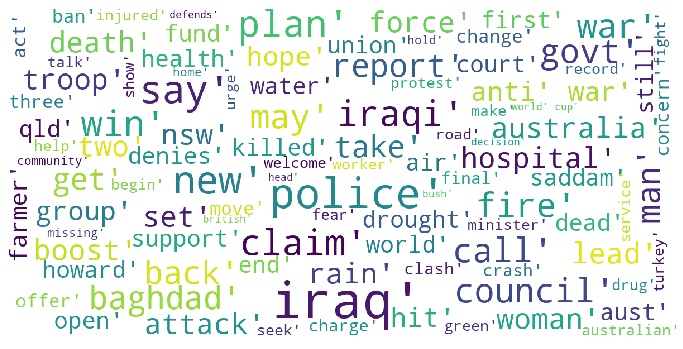

In [26]:
plot_wordcloud(news['headline_text'])

#### Text Blob

In [27]:

from textblob import TextBlob
    
def plot_polarity_histogram(text):
    
    def _polarity(text):
        return TextBlob(text).sentiment.polarity
        
    polarity_score =text.apply(lambda x : _polarity(x))
    polarity_score.hist()

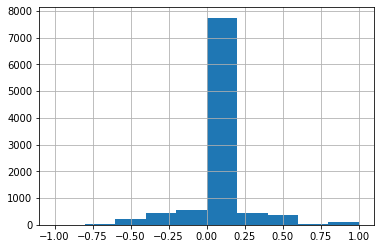

In [28]:
plot_polarity_histogram(news['headline_text'])

In [33]:

from textblob import TextBlob
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

def sentiment_vader(text, sid):
    ss = sid.polarity_scores(text)
    ss.pop('compound')
    return max(ss, key=ss.get)

def sentiment_textblob(text):
        x = TextBlob(text).sentiment.polarity
        
        if x<0:
            return 'neg'
        elif x==0:
            return 'neu'
        else:
            return 'pos'

def plot_sentiment_barchart(text, method='TextBlob'):
    if method == 'TextBlob':
        sentiment = text.map(lambda x: sentiment_textblob(x))
    elif method == 'Vader':
        nltk.download('vader_lexicon')
        sid = SentimentIntensityAnalyzer()
        sentiment = text.map(lambda x: sentiment_vader(x, sid=sid))
    else:
        raise ValueError('Textblob or Vader')
    
    plt.bar(sentiment.value_counts().index,
            sentiment.value_counts())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/nikhil/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


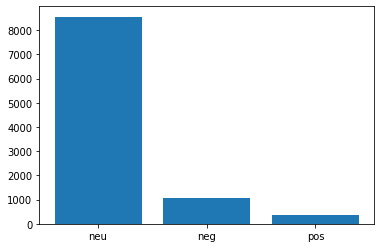

In [34]:
plot_sentiment_barchart(news['headline_text'], method='Vader')

### VADER

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/nikhil/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<BarContainer object of 3 artists>

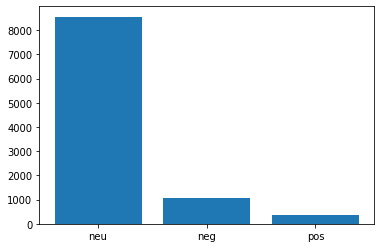

In [35]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    #return ss
    return np.argmax(list(ss.values())[:-1])

news['polarity']=news['headline_text'].\
    map(lambda x: get_vader_score(x))
polarity=news['polarity'].replace({0:'neg',1:'neu',2:'pos'})

plt.bar(polarity.value_counts().index,
        polarity.value_counts())

### Named Entity Recognition

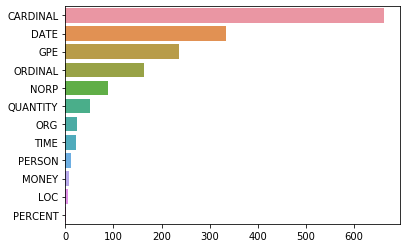

In [40]:

import spacy
from collections import  Counter
import seaborn as sns

def plot_named_entity_barchart(text):
    nlp = spacy.load("en_core_web_sm")
    
    def _get_ner(text):
        doc=nlp(text)
        return [X.label_ for X in doc.ents]
    
    ent=text.apply(lambda x : _get_ner(x))
    ent=[x for sub in ent for x in sub]
    counter=Counter(ent)
    count=counter.most_common()
    
    x,y=map(list,zip(*count))
    sns.barplot(x=y,y=x)


plot_named_entity_barchart(news['headline_text'])

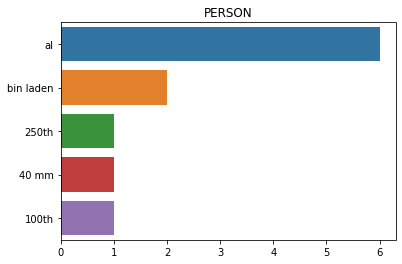

In [41]:

def plot_most_common_named_entity_barchart(text, entity="PERSON"):
    nlp = spacy.load("en_core_web_sm")
    
    def _get_ner(text,ent):
        doc=nlp(text)
        return [X.text for X in doc.ents if X.label_ == ent]

    entity_filtered=text.apply(lambda x: _get_ner(x,entity))
    entity_filtered=[i for x in entity_filtered for i in x]
    
    counter=Counter(entity_filtered)
    x,y=map(list,zip(*counter.most_common(10)))
    sns.barplot(y,x).set_title(entity)



plot_most_common_named_entity_barchart(news['headline_text'], entity="PERSON")

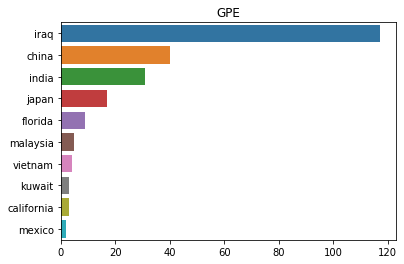

In [42]:
plot_most_common_named_entity_barchart(news['headline_text'], entity="GPE")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nikhil/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


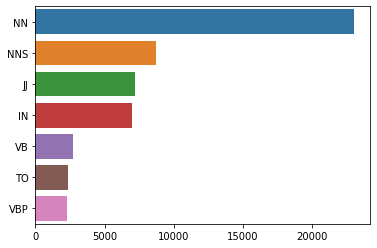

In [43]:

def plot_parts_of_speach_barchart(text):
    nltk.download('averaged_perceptron_tagger')

    def _get_pos(text):
        pos=nltk.pos_tag(word_tokenize(text))
        pos=list(map(list,zip(*pos)))[1]
        return pos
    
    tags=text.apply(lambda x : _get_pos(x))
    tags=[x for l in tags for x in l]
    counter=Counter(tags)
    x,y=list(map(list,zip(*counter.most_common(7))))
    
    sns.barplot(x=y,y=x)


plot_parts_of_speach_barchart(news['headline_text'])

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nikhil/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


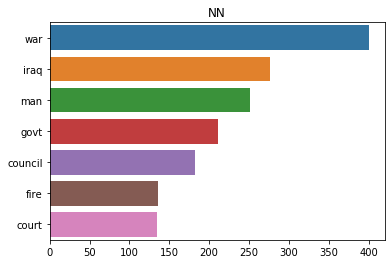

In [44]:

def plot_most_common_part_of_speach_barchart(text, part_of_speach='NN'):
    nltk.download('averaged_perceptron_tagger')
    
    def _filter_pos(text):
        pos_type=[]
        pos=nltk.pos_tag(word_tokenize(text))
        for word,tag in pos:
            if tag==part_of_speach:
                pos_type.append(word)
        return pos_type


    words=text.apply(lambda x : _filter_pos(x))
    words=[x for l in words for x in l]
    counter=Counter(words)
    x,y=list(map(list,zip(*counter.most_common(7))))
    sns.barplot(x=y,y=x).set_title(part_of_speach)


plot_most_common_part_of_speach_barchart(news['headline_text'])

#### Text Complexity

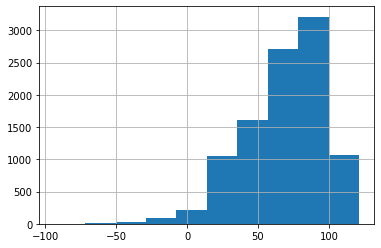

In [46]:
from textstat import flesch_reading_ease

def plot_text_complexity_histogram(text):
    text.\
        apply(lambda x : flesch_reading_ease(x)).\
        hist()



plot_text_complexity_histogram(news['headline_text'])